Import packages and navigate to model data directory

In [1]:
# Import packages
import os
import emc2
import xarray as xr
import pandas as pd
import numpy as np
from emc2.core import Instrument
from emc2.core.instrument import ureg
from emc2.core import Model
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from datetime import datetime, timedelta
import netCDF4 as nc
from emc2.core.instruments import HSRL
from emc2.core.instruments import WACR

# Navigate to the ACCESS-AM2 data directory
os.chdir('/g/data/jk72/ck4840/projects/emc2/data/access_am2')
# Check current project directory
print("Project directory:", os.getcwd())

Project directory: /g/data/jk72/ck4840/projects/emc2/data/access_am2


Create the ACCESS-AM2 model class

In [33]:
class ACCESS_AM2(emc2.core.Model):
    def __init__(self, file_path):
       """
       This loads an ACCESS-AM2 simulation with all of the necessary parameters for EMC^2 to run.
       
       Parameters
       ----------
       file_path: str
           Path to an ACCESS-AM2 simulation.
       time_range: tuple, list, or array, typically in datetime64 format
           Two-element array with starting and ending of time range.
       load_processed: bool
           If True, treating the 'file_path' variable as an EMC2-processed dataset; thus skipping dimension stacking as part of pre-processing.
       """
       
       super().__init__()
       
       # Bulk density
       self.Rho_hyd = {'cl': 1000. * ureg.kg / (ureg.m**3),
                       'ci': 500.  * ureg.kg / (ureg.m**3),
                       'pl': 1000. * ureg.kg / (ureg.m**3),
                       'pi': 250.  * ureg.kg / (ureg.m**3)}
       self.fluffy = {'ci': 0.5 * ureg.dimensionless,
                      'pi': 0.5 * ureg.dimensionless}
       # Lidar ratio
       self.lidar_ratio = {'cl': 18.  * ureg.dimensionless,
                           'ci': 24.  * ureg.dimensionless,
                           'pl': 5.5  * ureg.dimensionless,
                           'pi': 24.0 * ureg.dimensionless}
       # Lidar LDR per hydrometeor mass content
       self.LDR_per_hyd = {'cl': 0.03 * 1 / (ureg.kg / (ureg.m**3)),
                           'ci': 0.35 * 1 / (ureg.kg / (ureg.m**3)),
                           'pl': 0.1  * 1 / (ureg.kg / (ureg.m**3)),
                           'pi': 0.40 * 1 / (ureg.kg / (ureg.m**3))}
       # a, b in V = aD^b
       self.vel_param_a = {'cl': 3e7,
                           'ci': 700.,
                           'pl': 841.997,
                           'pi': 11.72}
       self.vel_param_b = {'cl': 2.   * ureg.dimensionless,
                           'ci': 1.   * ureg.dimensionless,
                           'pl': 0.8  * ureg.dimensionless,
                           'pi': 0.41 * ureg.dimensionless}
       super()._add_vel_units()
       # Names of mixing ratios of species
       # What is the difference between field254 and field392? Also, what is the difference between field12 and field393?
       self.q_names = {'cl': 'field254', 'ci': 'field12', 'pl': 'field394', 'pi': 'field396'}
       # Number concentration of each species
       self.N_field = {'cl': 'field4210', 'ci': 'custom_ncf_field', 'pl': 'zeros_var', 'pi': 'zeros_var'} # Need number concentrations of each species
       # Convective fraction
       self.conv_frac_names = {'cl': 'zeros_var', 'ci': 'zeros_var', 'pl': 'zeros_var', 'pi': 'zeros_var'}
       self.conv_frac_names_for_rad = {'cl': 'zeros_var', 'ci': 'zeros_var', 'pl': 'zeros_var', 'pi': 'zeros_var'}
       # Stratiform fraction
       self.strat_frac_names = {'cl': 'field267', 'ci': 'field268', 'pl': 'zeros_var', 'pi': 'zeros_var'}
       self.strat_frac_names_for_rad = {'cl': 'field267', 'ci': 'field268', 'pl': 'zeros_var', 'pi': 'zeros_var'}
       # Effective radius
       self.re_fields = {'cl': 're_cl', 'ci': 're_ci', 'pl': 're_pl', 'pi': 're_pi'}
       self.strat_re_fields = {'cl': 're_cl', 'ci': 're_ci', 'pl': 're_pl', 'pi': 're_pi'}
       self.conv_re_fields = {'cl': 'zeros_var', 'ci': 'zeros_var', 'pl': 'zeros_var', 'pi': 'zeros_var'}
       # Convective mixing ratio
       self.q_names_convective = {'cl': 'zeros_var', 'ci': 'zeros_var', 'pl': 'zeros_var', 'pi': 'zeros_var'}
       # Stratiform mixing ratio
       self.q_names_stratiform = {'cl': 'field254', 'ci': 'field12', 'pl': 'field394', 'pi': 'field396'}
       # Water vapor mixing ratio
       self.q_field = "hus"
       # Pressure
       self.p_field = "field408"
       # Height
       self.z_field = "z"
       # Temperature
       self.T_field = "ta"
       # Name of height dimension
       self.height_dim = "z1_hybrid_height"
       # Name of time dimension
       self.time_dim = "time"
       self.hyd_types = ["cl", "ci", "pl", "pi"]
       self.process_conv = False
       self.model_name = "ACCESS_AM2"
       # self.ds = xr.open_dataset(file_path)
       self.ds = ACCESS_AM2_output_subset

Create the MPL instrument class instance

In [34]:
MPL = HSRL()
# print(dir(MPL))

Create the MWACR instrument class instance

In [35]:
MWACR = WACR(site = 'micre')
# print(dir(MWACR))

Create the ACCESS-AM2 model class instance

In [36]:
ACCESS_AM2_instance = ACCESS_AM2(ACCESS_AM2_output_subset)
# print(dir(ACCESS_AM2_instance))

Create simulated data from ACCESS_AM2_instance and MPL

In [37]:
# Create simulated lidar data
marcus_MPL_ACCESS_AM2_model = emc2.simulator.main.make_simulated_data(ACCESS_AM2_instance, MPL, N_columns = 1, do_classify = True, convert_zeros_to_nan = True, use_rad_logic = False, parallel = False)
# dir(marcus_MPL_ACCESS_AM2_model)

## Creating subcolumns...
No convective processing for ACCESS_AM2
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns frac fields to 1 for startiform cl and ci based on q > 0. kg/kg
Done! total processing time = 0.01s
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns frac fields to 1 for strat precip based on q > 0. kg/kg
Done! total processing time = 0.01s
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for cl equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for ci equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for pl equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for pi equal to grid-cell mean
Generating lidar moments...
Generating stratiform lidar variable

In [38]:
# # Create simulated radar data
marcus_MWACR_ACCESS_AM2_model = emc2.simulator.main.make_simulated_data(ACCESS_AM2_instance, MWACR, N_columns = 1, do_classify = True, convert_zeros_to_nan = True, use_rad_logic = False, parallel = False)
# dir(marcus_MWACR_ACCESS_AM2_model)

## Creating subcolumns...
No convective processing for ACCESS_AM2
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns frac fields to 1 for startiform cl and ci based on q > 0. kg/kg
Done! total processing time = 0.01s
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns frac fields to 1 for strat precip based on q > 0. kg/kg
Done! total processing time = 0.01s
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for cl equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for ci equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for pl equal to grid-cell mean
num_subcolumns == 1 (subcolumn generator turned off); setting subcolumns q (and N micro logic) fields for pi equal to grid-cell mean
Generating radar moments...
Generating stratiform radar variable

In [39]:
backscatter = marcus_MPL_ACCESS_AM2_model.ds['sub_col_beta_p_tot'].values
backscatter[np.isinf(backscatter)] = np.nan
print(np.nanmax(backscatter[np.nonzero(backscatter)]))
print(np.nanmin(backscatter[np.nonzero(backscatter)]))
print(backscatter[0,12])

0.1069895881477876
4.2167615954244447e-10
[1.16318532e-07 1.32489008e-07 1.61929928e-07 3.35913422e-03
 7.96319662e-03 1.01299641e-02 6.29794812e-03 2.03046413e-03
 7.64375566e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.14869508e-03 4.97572645e-03 5.79019385e-03 6.21862514e-03
 6.40671228e-03 6.10114017e-03 5.59831830e-03 5.01108402e-03
 4.39946231e-03 3.76885373e-03 3.17986293e-03 2.61955769e-03
 2.13722058e-03 1.70592392e-03 1.28417690e-03 9.15759739e-04
 6.59543241e-04 4.84981031e-04 3.57157149e-04 2.63309834e-04
 1.95453564e-04 1.46154283e-04 1.11583072e-04 8.86036778e-05
 7.24636906e-05 6.02578595e-05 4.83969460e-05 3.35564562e-05
 3.10462106e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+

In [40]:
depol = marcus_MPL_ACCESS_AM2_model.ds['sub_col_LDR_strat'].values
depol[np.isinf(backscatter)] = np.nan
print(np.nanmax(depol[np.nonzero(depol)]))
print(np.nanmin(depol[np.nonzero(depol)]))
print(depol[0,12])

0.35000000000000003
0.2521239051678627
[0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35  nan  nan  nan 0.35 0.35
 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35
 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35 0.35  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan]


In [41]:
reflectivity = marcus_MWACR_ACCESS_AM2_model.ds['sub_col_Ze_tot_strat'].values
reflectivity[np.isinf(reflectivity)] = np.nan
print(np.nanmax(reflectivity[np.nonzero(reflectivity)]))
print(np.nanmin(reflectivity[np.nonzero(reflectivity)]))
print(reflectivity[0,12])

-33.457212477712915
-120.70602614147242
[          nan           nan           nan  -59.72390427  -53.4986251
  -54.28735189  -58.41552925  -65.74390277  -57.54428383           nan
           nan           nan  -65.53086843  -63.16644669  -62.40393349
  -62.00318878  -61.8769468   -62.23088522  -62.79971602  -63.50892707
  -64.32258822  -65.2692837   -66.2858114   -67.42564902  -68.60684697
  -69.90345966  -71.53267355  -73.50585516  -75.53500135  -77.60442462
  -79.87324986  -82.41220338  -85.30563899  -88.68318845  -92.52669023
  -96.57311572 -100.51157377 -103.94143409 -107.39771588 -112.120334
 -108.67419849           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           n

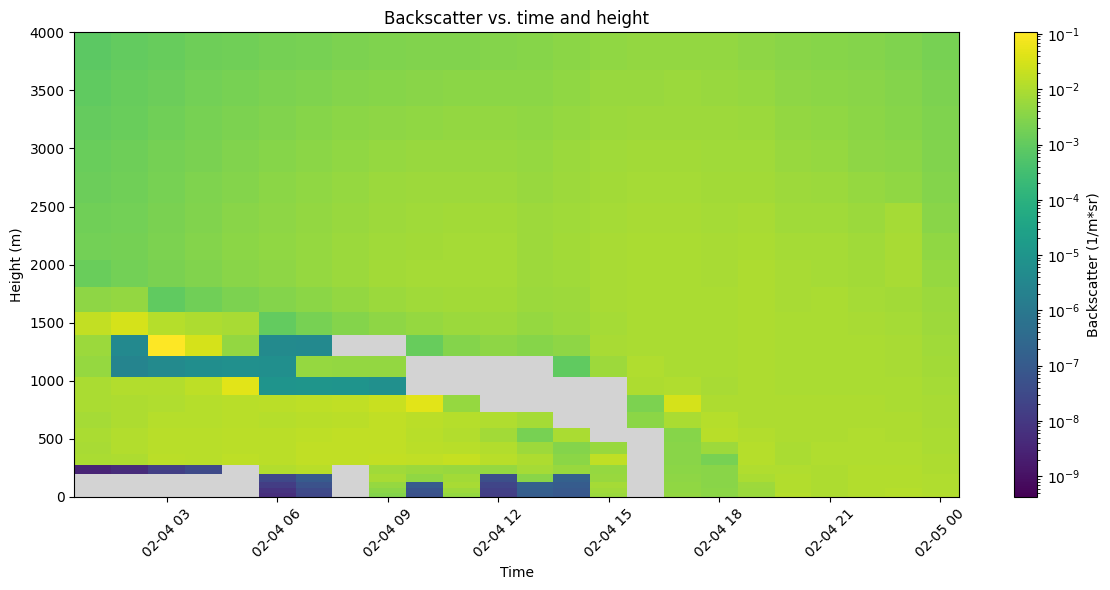

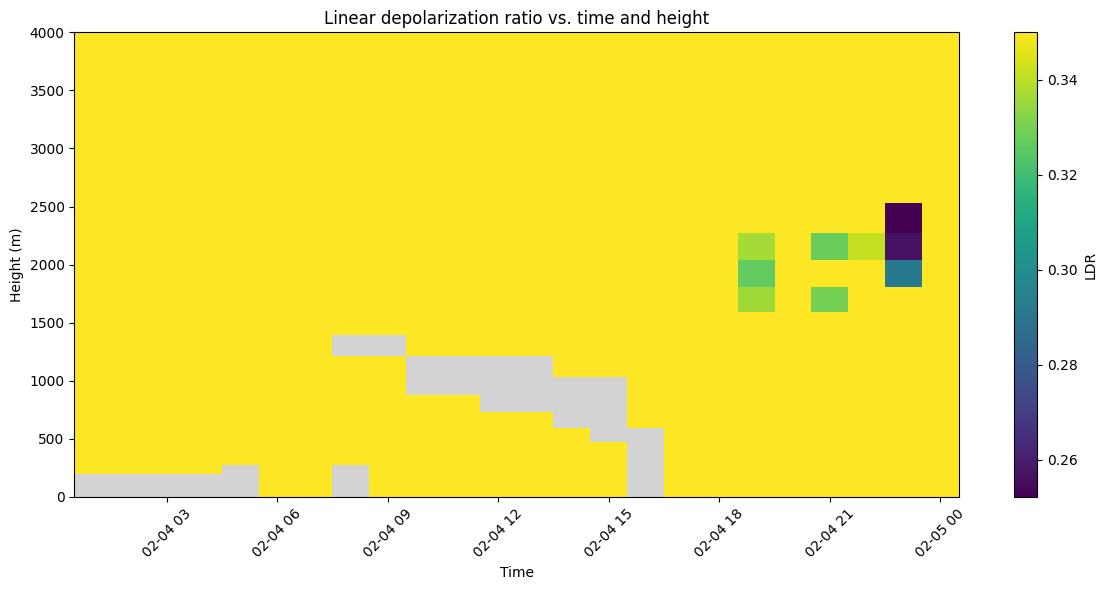

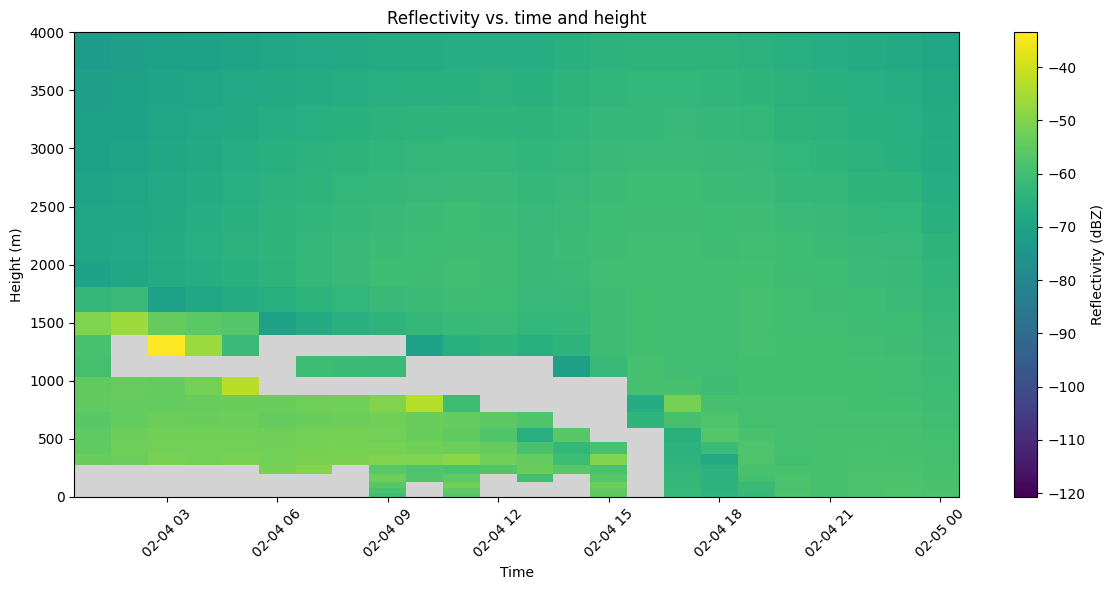

In [42]:
# Save the plot
# UM_reg_emc2_output_backscatter.savefig(f'/g/data/jk72/ck4840/projects/emc2/figs/um_reg/emc2_test/UM_reg_emc2_output_backscatter_{current_date_str}', dpi = 200)
# Open files and extract current date

# Create a meshgrid for time and height to be used for all plots produced from the current file
time_mesh, height_mesh = np.meshgrid(marcus_MPL_ACCESS_AM2_model.ds['time'], marcus_MPL_ACCESS_AM2_model.ds['z1_hybrid_height'])

# Backscatter
# Extract the desired variable
backscatter = marcus_MPL_ACCESS_AM2_model.ds['sub_col_beta_p_tot_strat'].isel(subcolumn=0).drop('subcolumn')
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, backscatter.T, cmap = 'viridis', shading = 'auto', norm = LogNorm())
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'Backscatter (1/m*sr)')
plt.title('Backscatter vs. time and height')
plt.ylim(0, 4000)
plt.xticks(rotation = 45)
plt.tight_layout()
UM_reg_emc2_output_backscatter = plt.gcf()

# Depol
# Extract the desired variable
depol = marcus_MPL_ACCESS_AM2_model.ds['sub_col_LDR_strat'].isel(subcolumn=0).drop('subcolumn')
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, depol.T, cmap = 'viridis', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'LDR')
plt.title('Linear depolarization ratio vs. time and height')
plt.ylim(0, 4000)
plt.xticks(rotation = 45)
plt.tight_layout()
UM_reg_emc2_output_depol = plt.gcf()

# Reflectivity
# Extract the desired variable
reflectivity = marcus_MPL_ACCESS_AM2_model.ds['sub_col_Ze_tot_strat'].isel(subcolumn=0).drop('subcolumn')
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, reflectivity.T, cmap = 'viridis', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'Reflectivity (dBZ)')
plt.title('Reflectivity vs. time and height')
plt.ylim(0, 4000)
plt.xticks(rotation = 45)
plt.tight_layout()
UM_reg_emc2_output_reflectivity = plt.gcf()